In [110]:
import os
from pathlib import Path
import logging
import random
import itertools
from tqdm import tqdm

import pprint
import hdbscan
# import umap.umap_ as umap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.spatial.distance import cdist

from capstone.config import CapstoneConfig
from capstone.data_access import DataClass
from capstone.features import Features
from capstone.evaluation import CustomEvaluation
from capstone.utils.constants import (
    TEXT,
    TARGET,
    ORIGINAL_TEXT,
    SPLIT,
    DEVELOP,
    TEST,
    PREDICTION,
    SAVED_MODELS
)

pp = pprint.PrettyPrinter(depth=4)
sns.set_style("darkgrid")
PARENT_PATH = Path(os.getcwd()).parent.absolute()
FORMAT = "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
logging.basicConfig(format=FORMAT, level=logging.INFO)

seed = 666
random.seed(seed)
np.random.seed(seed)

In [4]:
config = CapstoneConfig()
config.CURRENT_PATH = PARENT_PATH

data = DataClass(config)
df = data.build()
df.head(3)

,Text,Standard mapping?
0,General Quality System Requirements […] Manage...,"[quality management, quality planning]"
1,General Quality System Requirements […] Manage...,[quality management]
2,General Quality System Requirements […] Manage...,[quality management]


In [5]:
features = Features(config)
df_features = features.build(df)

df_features.head(3)

2022-12-11 11:14:50,191 - capstone.utils.utils - INFO - func:clean took: 3.38 sec
2022-12-11 11:14:50,829 - capstone.utils.utils - INFO - func:fit took: 4.02 sec
2022-12-11 11:14:52,604 - capstone.utils.utils - INFO - func:clean took: 1.77 sec
2022-12-11 11:14:52,843 - capstone.utils.utils - INFO - func:transform took: 2.01 sec
2022-12-11 11:14:52,844 - capstone.utils.utils - INFO - func:fit_transform took: 6.03 sec
2022-12-11 11:14:53,037 - capstone.utils.utils - INFO - func:clean took: 0.19 sec
2022-12-11 11:14:53,063 - capstone.utils.utils - INFO - func:transform took: 0.22 sec
2022-12-11 11:14:53,090 - capstone.utils.utils - INFO - func:build took: 6.30 sec


,Text,Standard mapping?,Original Text,audit inspection,calibration,capa,change controls,clinical research,controled substances,csv,...,word__unit generally,word__unit generally shared,word__use device,word__used manufacture,word__used production,word__validation study,word__way ensures,word__wholesale distributor,word__written procedure,Split
0,good practice quality control qc responsibilit...,"[laboratory controls, stability programs]",Good practices in quality control […] Other QC...,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.439675,Development
1,good practice quality control basic requiremen...,"[capa, nc, rca]",Good practices in quality control […] The basi...,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,Development
2,validation process validation program critical...,[process & packaging validation],Validation […] Process Validation Program […] ...,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.285952,0.0,0.0,0.000000,Development


In [6]:
# Reduce the dataset to contain only those regulation
# that map to a single quality topic
# Problem reduces to multi-class classification
df_features = df_features[df_features[TARGET].apply(lambda x: len(x)) == 1].copy()
df_features.reset_index(drop=True, inplace=True)

In [8]:
davinci_embeddings = pd.read_pickle(os.path.join(data.data_path, "davinci-embeddings.pkl"))
davinci_embeddings = pd.DataFrame(davinci_embeddings.items(), columns=[ORIGINAL_TEXT, "list_embeddings"])
davinci_embeddings[ORIGINAL_TEXT] = davinci_embeddings[ORIGINAL_TEXT].apply(lambda x: x[0])
df_features = pd.merge(df_features, davinci_embeddings, on=ORIGINAL_TEXT,  how="inner")


In [90]:
keep_topics = {
    "clinical research",
    "purchasing controls",
    "data management"
}

for topic in keep_topics:
    assert topic in features.mlb.classes_

def ifkeep(target, keep_topics):
    for y in target:
        if y not in keep_topics:
            return False
    return True

e = df_features.copy()
e = e[e[TARGET].apply(ifkeep, keep_topics=keep_topics)].copy()
e.reset_index(drop=True, inplace=True)
embeddings = np.array(e["list_embeddings"].values.tolist())
y_true = e[features.mlb.classes_].to_numpy().argmax(axis=1).reshape(-1,)

e.shape

# df_features[df_features[TARGET].apply(lambda x: x[0])=="qsmr"].shape
# df_features[df_features[TARGET].apply(lambda x: x[0])=="identification and traceability"].shape
# df_features[df_features[TARGET].apply(lambda x: x[0])=="csv"].shape


(549, 552)

In [91]:
embeddings.shape

(549, 12288)

In [92]:
y_true.shape

(549,)

Define utility functions

In [94]:
# Useful constants
CLUSTER = "cluster"
EMBEDDINGS = ["llm_{i}" for i in range(embeddings.shape[1])]
PCA_COMP = ["pca_1", "pca_2"]
TARGET_NUMERIC = "Target Numeric"

# Utility function to compute purity scores
def compute_purity(df):
    purity_scores = {}
    purity_scores_deep = {}
    clusters_unique = df[CLUSTER].unique()
    for c in clusters_unique:
        labels = df[df[CLUSTER]==c][TARGET_NUMERIC].tolist()
        sorted_labels = sorted(list(set(labels)), key=labels.count, reverse=True)
        mode = sorted_labels[0]
        if len(sorted_labels) > 1:
            mode2 = sorted_labels[1]
        else:
            mode2 = -1
        score = sum([1 if y==mode else 0 for y in labels]) / len(labels)
        score2 = sum([1 if y==mode2 else 0 for y in labels]) / len(labels)
        mode_label = features.mlb.classes_[mode]
        mode_label2 = features.mlb.classes_[mode2] if mode2 != -1 else -1
        purity_scores[c] = (score, mode_label)
        purity_scores_deep[c] = {mode_label: score, mode_label2: score2}
    return purity_scores, purity_scores_deep

# Utility function to find quality topics that did not win any cluster
def sanity_check(keep_topics, scores: dict()):
    counts = {}
    for c in scores:
        if scores[c][1] not in counts:
            counts[scores[c][1]] = 1
        else:
            counts[scores[c][1]] += 1
    missing = set(keep_topics) - set([c for c in counts])
    multiple = [(c, counts[c]) for c in counts if counts[c] > 1]
    return missing, multiple

k-Means (Floyd)

In [95]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(len(keep_topics)//2, len(keep_topics)+5)

for k in tqdm(K):
    # Building and fitting the model
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeanModel = kmeans.fit(embeddings)
    distortions.append(
        sum(np.min(
            cdist(embeddings, kmeanModel.cluster_centers_, 'euclidean'),
            axis=1
        )) / embeddings.shape[0]
    )
    inertias.append(kmeanModel.inertia_)
    mapping1[k] = sum(np.min(
        cdist(embeddings, kmeanModel.cluster_centers_, 'euclidean'),
        axis=1
    )) / embeddings.shape[0]
    mapping2[k] = kmeanModel.inertia_

100%|█████████████████████████████████████████████████████████████████| 7/7 [00:11<00:00,  1.59s/it]


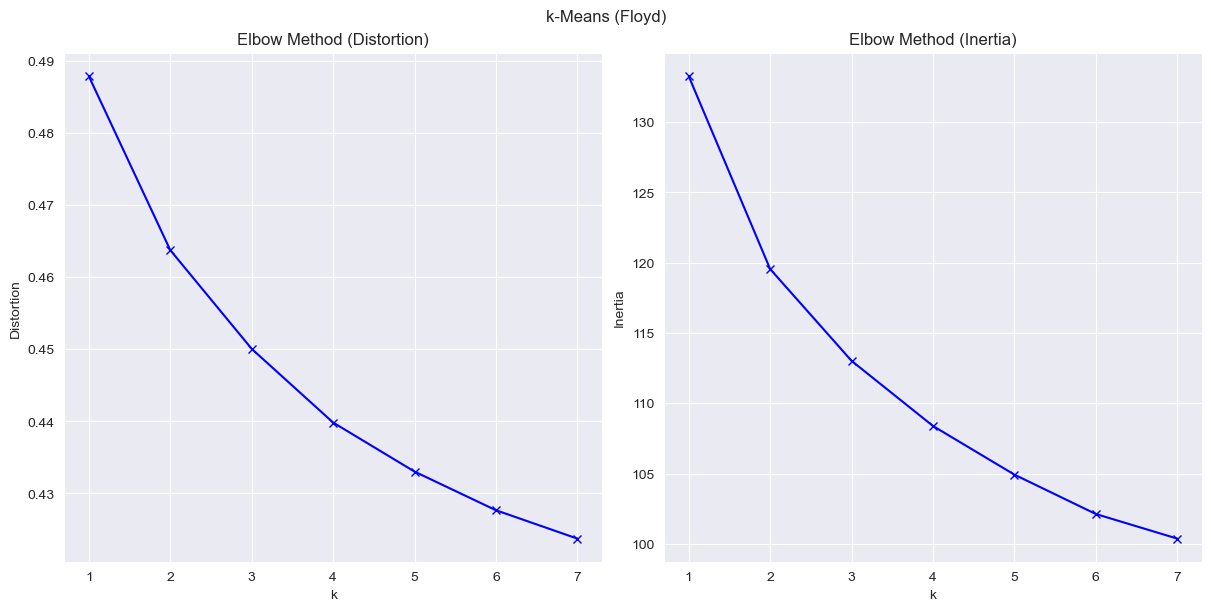

In [96]:
fig, ax = plt.subplots(1, 2, figsize=(12,6), constrained_layout=True)
ax[0].plot(K, distortions, 'bx-')
ax[0].set_xlabel('k')
ax[0].set_ylabel('Distortion')
ax[0].set_title('Elbow Method (Distortion)')
ax[1].plot(K, inertias, 'bx-')
ax[1].set_xlabel('k')
ax[1].set_ylabel('Inertia')
ax[1].set_title('Elbow Method (Inertia)')
fig.suptitle("k-Means (Floyd)");

In [97]:
k = len(keep_topics)
clustering_method = KMeans(n_clusters=k, random_state=0)
clusters = clustering_method.fit(embeddings)

dim_reduction_method = PCA(n_components=2)
embeddings_reduced = dim_reduction_method.fit_transform(embeddings)

embeddings_df = pd.DataFrame(embeddings, columns=EMBEDDINGS)
embeddings_df["x"] = embeddings_reduced[:,0]
embeddings_df["y"] = embeddings_reduced[:,1]
embeddings_df[CLUSTER] = clusters.labels_
embeddings_df[TARGET_NUMERIC] = y_true
embeddings_df[TARGET] = embeddings_df[TARGET_NUMERIC].apply(lambda x: features.mlb.classes_[x])

scores, scores_deep = compute_purity(embeddings_df)
pp.pprint(scores)

{0: (0.46808510638297873, 'data management'),
 1: (0.6029411764705882, 'purchasing controls'),
 2: (0.9852941176470589, 'clinical research')}


In [100]:
missing, multiple = sanity_check(keep_topics, scores)
print("Missing:")
pp.pprint(missing)
print("\n\nMultiple:")
pp.pprint(multiple)

Missing:
set()


Multiple:
[]


In [101]:
pp.pprint(scores_deep)

{0: {'clinical research': 0.3829787234042553,
     'data management': 0.46808510638297873},
 1: {'data management': 0.3872549019607843,
     'purchasing controls': 0.6029411764705882},
 2: {'clinical research': 0.9852941176470589,
     'data management': 0.014705882352941176}}


In [102]:
fig = px.scatter(
    embeddings_df,
    y="y",
    x="x",
    color=CLUSTER,
    symbol=TARGET,
    hover_data=[TARGET]
)
fig.update_layout(uniformtext_mode="hide")
fig.update_layout(legend_orientation="h")
fig.show()

In [103]:
clustering_method = KMeans(n_clusters=k, random_state=0)
clusters = clustering_method.fit(embeddings)

dim_reduction_method = TSNE(n_components=2)
embeddings_reduced = dim_reduction_method.fit_transform(embeddings)

embeddings_df = pd.DataFrame(embeddings, columns=EMBEDDINGS)
embeddings_df["x"] = embeddings_reduced[:,0]
embeddings_df["y"] = embeddings_reduced[:,1]
embeddings_df[CLUSTER] = clusters.labels_
embeddings_df[TARGET_NUMERIC] = y_true
embeddings_df[TARGET] = embeddings_df[TARGET_NUMERIC].apply(lambda x: features.mlb.classes_[x])

fig = px.scatter(
    embeddings_df,
    y="y",
    x="x",
    color=CLUSTER,
    symbol=TARGET,
    hover_data=[TARGET],
    title="k-Means & TSNE"
)
fig.update_layout(uniformtext_mode="hide")
fig.update_layout(legend_orientation="h")
fig.show();

/Users/vishweshwartyagi/miniconda3/envs/capstone/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/Users/vishweshwartyagi/miniconda3/envs/capstone/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



k-means (Elkan)

In [104]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}

for k in tqdm(K):
    # Building and fitting the model
    kmeans = KMeans(n_clusters=k, random_state=0, algorithm="elkan")
    kmeanModel = kmeans.fit(embeddings)
    distortions.append(
        sum(np.min(
            cdist(embeddings, kmeanModel.cluster_centers_, 'euclidean'),
            axis=1
        )) / embeddings.shape[0]
    )
    inertias.append(kmeanModel.inertia_)
    mapping1[k] = sum(np.min(
        cdist(embeddings, kmeanModel.cluster_centers_, 'euclidean'),
        axis=1
    )) / embeddings.shape[0]
    mapping2[k] = kmeanModel.inertia_

  0%|                                                                         | 0/7 [00:00<?, ?it/s]/Users/vishweshwartyagi/miniconda3/envs/capstone/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1325: RuntimeWarning:

algorithm='elkan' doesn't make sense for a single cluster. Using 'lloyd' instead.

100%|█████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.45s/it]


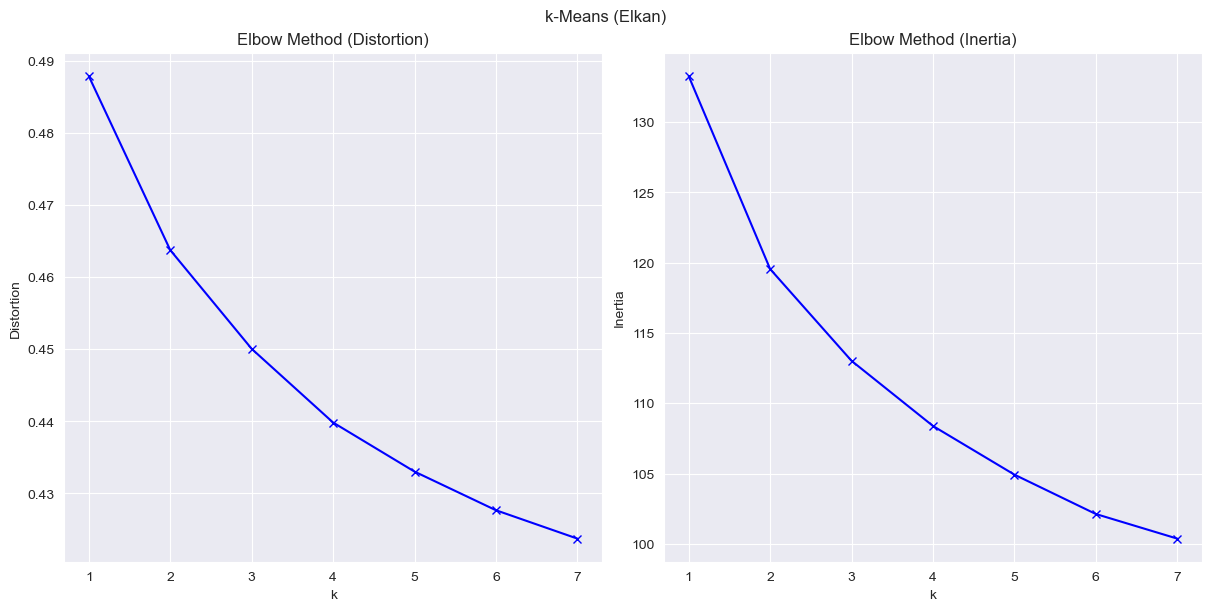

In [105]:
fig, ax = plt.subplots(1, 2, figsize=(12,6), constrained_layout=True)
ax[0].plot(K, distortions, 'bx-')
ax[0].set_xlabel('k')
ax[0].set_ylabel('Distortion')
ax[0].set_title('Elbow Method (Distortion)')
ax[1].plot(K, inertias, 'bx-')
ax[1].set_xlabel('k')
ax[1].set_ylabel('Inertia')
ax[1].set_title('Elbow Method (Inertia)')
fig.suptitle("k-Means (Elkan)");

In [106]:
k = len(keep_topics)
clustering_method = KMeans(n_clusters=k, random_state=0, algorithm="elkan")
clusters = clustering_method.fit(embeddings)

dim_reduction_method = PCA(n_components=2)
embeddings_reduced = dim_reduction_method.fit_transform(embeddings)

embeddings_df = pd.DataFrame(embeddings, columns=EMBEDDINGS)
embeddings_df["x"] = embeddings_reduced[:,0]
embeddings_df["y"] = embeddings_reduced[:,1]
embeddings_df[CLUSTER] = clusters.labels_
embeddings_df[TARGET_NUMERIC] = y_true
embeddings_df[TARGET] = embeddings_df[TARGET_NUMERIC].apply(lambda x: features.mlb.classes_[x])

scores, scores_deep = compute_purity(embeddings_df)
pp.pprint(scores)

{0: (0.46808510638297873, 'data management'),
 1: (0.6029411764705882, 'purchasing controls'),
 2: (0.9852941176470589, 'clinical research')}


In [107]:
missing, multiple = sanity_check(keep_topics, scores)
print("Missing:")
pp.pprint(missing)
print("\n\nMultiple:")
pp.pprint(multiple)

Missing:
set()


Multiple:
[]


In [108]:
pp.pprint(scores_deep)

{0: {'clinical research': 0.3829787234042553,
     'data management': 0.46808510638297873},
 1: {'data management': 0.3872549019607843,
     'purchasing controls': 0.6029411764705882},
 2: {'clinical research': 0.9852941176470589,
     'data management': 0.014705882352941176}}


In [109]:
fig = px.scatter(
    embeddings_df,
    y="y",
    x="x",
    color=CLUSTER,
    symbol=TARGET,
    hover_data=[TARGET],
    title="k-Means & PCA"
)
fig.update_layout(uniformtext_mode="hide")
fig.update_layout(legend_orientation="h")
fig.show()

Hierarchical Clustering (HDBSCAN)

This algorithm figures out the number of clusters on its own

In [111]:
clustering_method = hdbscan.HDBSCAN(
    min_cluster_size=15,
    metric="euclidean",
    cluster_selection_method="eom"
)
clusters = clustering_method.fit(embeddings)

dim_reduction_method = PCA(n_components=2)
embeddings_reduced = dim_reduction_method.fit_transform(embeddings)

embeddings_df = pd.DataFrame(embeddings, columns=EMBEDDINGS)
embeddings_df["x"] = embeddings_reduced[:,0]
embeddings_df["y"] = embeddings_reduced[:,1]
embeddings_df[CLUSTER] = clusters.labels_
embeddings_df[TARGET_NUMERIC] = y_true
embeddings_df[TARGET] = embeddings_df[TARGET_NUMERIC].apply(lambda x: features.mlb.classes_[x])

scores, scores_deep = compute_purity(embeddings_df)
pp.pprint(scores)

{-1: (0.4681238615664845, 'clinical research')}


Unclustered Samples

In [112]:
f"{sum(embeddings_df[CLUSTER] == -1) / len(embeddings_df) * 100:.3}%"

'1e+02%'

In [116]:
missing, multiple = sanity_check(keep_topics, scores)
print("Missing:")
pp.pprint(missing)
print("\n\nMultiple:")
pp.pprint(multiple)

Missing:
{'purchasing controls', 'data management'}


Multiple:
[]


In [32]:
df_features[df_features[TARGET].apply(lambda x: x[0]) == "capa"].shape

(0, 551)

In [33]:
df_features[df_features[TARGET].apply(lambda x: x[0]) == "facilities"].shape

(0, 551)

In [34]:
df_features[df_features[TARGET].apply(lambda x: x[0]) == "handling"].shape

(0, 551)

In [35]:
df_features[df_features[TARGET].apply(lambda x: x[0]) == "nc"].shape

(0, 551)

In [38]:
df_features[df_features[TARGET].apply(lambda x: x[0]) == "rca"].shape

(0, 551)

In [37]:
df_features[df_features[TARGET].apply(lambda x: x[0]) == "qsmr"].shape

(3, 551)

In [41]:
df_features[df_features[TARGET].apply(lambda x: x[0]) == "rca"].shape

(0, 551)

In [39]:
df_features[df_features[TARGET].apply(lambda x: x[0]) == "storage and distribution"].shape

(0, 551)

In [40]:
df_features[df_features[TARGET].apply(lambda x: x[0]) == "utilities and equipment"].shape

(0, 551)

In [29]:
pp.pprint(scores_deep)

{-1: {'production process controls': 0.11428571428571428,
      'quality planning': 0.17142857142857143},
 0: {-1: 0.0, 'stability programs': 1.0},
 1: {-1: 0.0, 'controled substances': 1.0},
 2: {-1: 0.0, 'calibration': 1.0},
 3: {'md product cybersecurity': 0.018867924528301886,
     'samd': 0.9622641509433962},
 4: {'clinical research': 0.9883720930232558,
     'documentation management': 0.003875968992248062},
 5: {'laboratory controls': 0.9882352941176471,
     'production process controls': 0.011764705882352941},
 6: {-1: 0.0, 'non clinical research': 1.0},
 7: {'identification and traceability': 0.9375,
     'labeling and packaging operations': 0.0625},
 8: {'labeling and packaging operations': 0.9773755656108597,
     'production process controls': 0.00904977375565611},
 9: {-1: 0.0, 'udi and serialization': 1.0},
 10: {'design controls': 0.989010989010989,
      'laboratory controls': 0.01098901098901099},
 11: {-1: 0.0, 'vigilance': 1.0},
 12: {-1: 0.0, 'medical device post m

In [30]:
fig = px.scatter(
    embeddings_df,
    y="y",
    x="x",
    color=CLUSTER,
    symbol=TARGET,
    hover_data=[TARGET],
    title="HDBSCAN & PCA"
)
fig.update_layout(uniformtext_mode="hide")
fig.update_layout(legend_orientation="h")
fig.show();

In [117]:
clustering_method = hdbscan.HDBSCAN(
    min_cluster_size=15,
    metric="euclidean",
    cluster_selection_method="eom"
)
clusters = clustering_method.fit(embeddings)

dim_reduction_method = TSNE(n_components=2)
embeddings_reduced = dim_reduction_method.fit_transform(embeddings)

embeddings_df = pd.DataFrame(embeddings, columns=EMBEDDINGS)
embeddings_df["x"] = embeddings_reduced[:,0]
embeddings_df["y"] = embeddings_reduced[:,1]
embeddings_df[CLUSTER] = clusters.labels_
embeddings_df[TARGET_NUMERIC] = y_true
embeddings_df[TARGET] = embeddings_df[TARGET_NUMERIC].apply(lambda x: features.mlb.classes_[x])

fig = px.scatter(
    embeddings_df,
    y="y",
    x="x",
    color=CLUSTER,
    symbol=TARGET,
    hover_data=[TARGET],
    title="HDBSCAN & TSNE"
)
fig.update_layout(uniformtext_mode="hide")
fig.update_layout(legend_orientation="h")
fig.show();